In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.author_vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

In [2]:
test_data = pd.read_pickle('../data/04c_Test_Set.pkl')

# Style Embeddings from Style Model

In [3]:
model = StyleModel()
model.load_state_dict(torch.load('../model/TestData_StyleModel.pt'))

<All keys matched successfully>

In [4]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 10684/10684 [05:24<00:00, 32.91it/s]


## Centroids

In [5]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [6]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.index = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']
distances.columns = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6
0,0.000,1.350,1.307,1.531,1.245,1.333,1.303
1,0.000,0.000,1.365,1.588,1.314,1.388,1.344
2,0.000,0.000,0.000,1.550,1.277,1.329,1.299
3,0.000,0.000,0.000,0.000,1.505,1.567,1.531
4,0.000,0.000,0.000,0.000,0.000,1.298,1.261
5,0.000,0.000,0.000,0.000,0.000,0.000,1.313
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

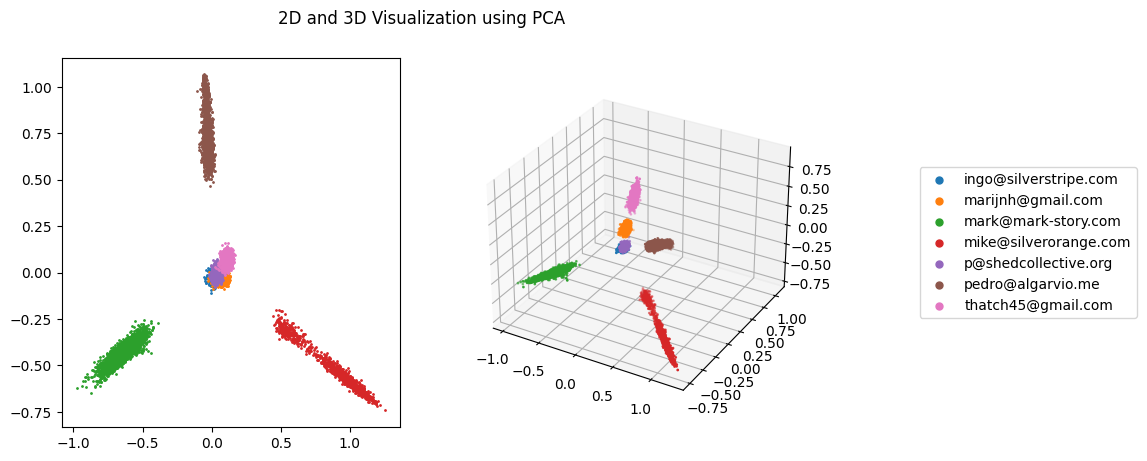

In [7]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

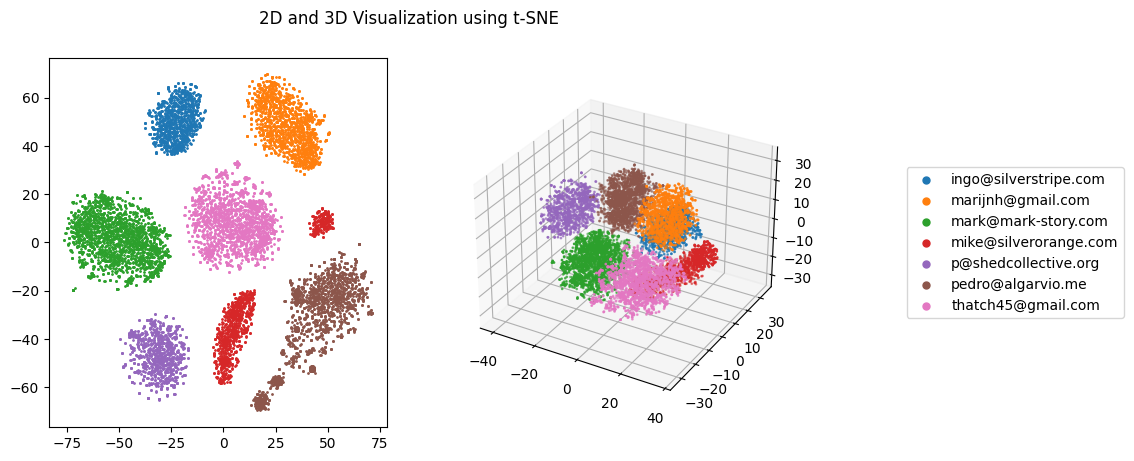

In [8]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 8
10 Most common:
[(2, 2082), (6, 1969), (5, 1907), (1, 1496), (3, 1103), (4, 1078), (0, 989), (-1, 60)]


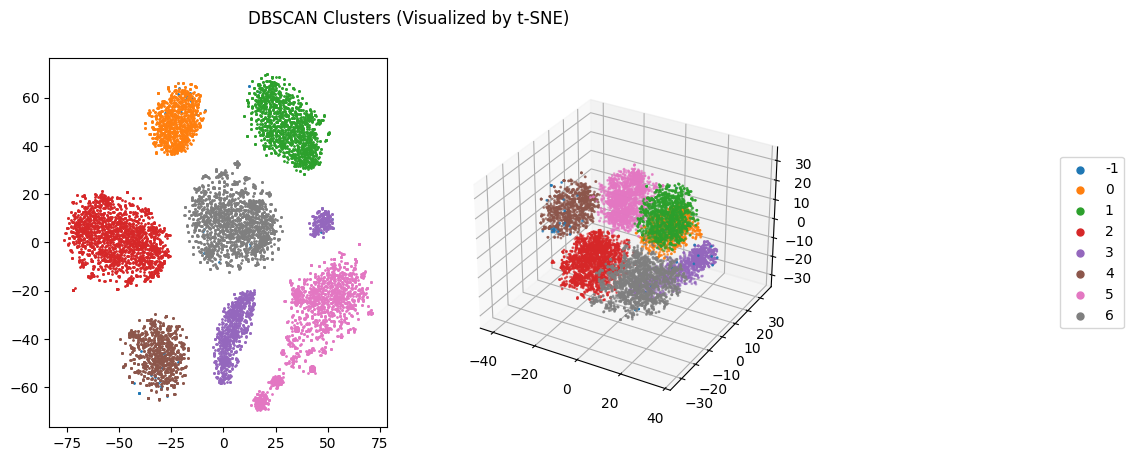

In [9]:
dbscan_model = DBSCAN(eps=0.39, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [10]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,60.0,5.0,7.0,"('p@shedcollective.org', 25)",23.0,1.0,"('nails_common', 13)"
1,989.0,1.0,989.0,"('ingo@silverstripe.com', 989)",28.0,4.0,"('silverstripe_silverstripe-framework', 597)"
2,1496.0,1.0,1496.0,"('marijnh@gmail.com', 1496)",11.0,31.0,"('codemirror_CodeMirror', 1045)"
3,2082.0,1.0,2082.0,"('mark@mark-story.com', 2082)",11.0,6.0,"('cakephp_cakephp', 1950)"
4,1103.0,1.0,1103.0,"('mike@silverorange.com', 1103)",8.0,4.5,"('silverorange_swat', 1051)"
5,1078.0,1.0,1078.0,"('p@shedcollective.org', 1078)",23.0,12.0,"('nails_common', 457)"
6,1907.0,1.0,1907.0,"('pedro@algarvio.me', 1907)",9.0,2.0,"('saltstack_salt', 1822)"
7,1969.0,1.0,1969.0,"('thatch45@gmail.com', 1969)",1.0,1969.0,"('saltstack_salt', 1969)"


In [11]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,8.000000,8.000000,8.000000,8.000000,8.000000
mean,1335.500000,1.500000,1328.875000,14.250000,253.687500
std,673.825115,1.414214,688.263122,9.300538,693.158863
min,60.000000,1.000000,7.000000,1.000000,1.000000
25%,1055.750000,1.000000,1055.750000,8.750000,3.500000
50%,1299.500000,1.000000,1299.500000,11.000000,5.250000
75%,1922.500000,1.000000,1922.500000,23.000000,16.750000
max,2082.000000,5.000000,2082.000000,28.000000,1969.000000


In [12]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0,1,2,3,4,5,6,7
length_mean,50.166667,150.004044,77.235294,89.800192,74.848595,55.389610,60.113267,53.189944
length_std,39.320125,87.582715,42.744259,64.121144,48.459269,25.894075,38.870751,36.456009
n_uppercase_mean,2.933333,12.490394,3.080214,3.889529,3.388033,2.756030,2.464604,1.158456
n_uppercase_std,2.803965,6.411974,2.045011,3.626974,2.816852,3.238915,2.518142,1.291564
polarity_mean,0.049028,0.026251,0.014020,0.003244,0.029088,-0.008275,0.000266,0.027259
polarity_std,0.162668,0.159737,0.189607,0.189677,0.173223,0.178785,0.153540,0.193829
subjectivity_mean,0.216040,0.287865,0.217588,0.200823,0.178733,0.157538,0.140582,0.188428
subjectivity_std,0.303059,0.243414,0.297424,0.281435,0.292501,0.278404,0.253164,0.294804


In [13]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
Set omnipay response earlier in PurchaseService

It might be used in onCaptured callbacks
___
2) 
Added iShouldSeeAButton assertion
___
3) 
Registering Te Reo support in i<I>n
___
4) 
Check route info array in dev/graphiql (#<I>)

Route definitions have more than one allowed format,

either a plain string, or an object with a 'Controller' key.

We've changed the /graphql endpoint to the latter in order

to set the 'Stage' as well, which broke dev/graphiql.
___
5) 
Check for $bounceAddress before using (fixes #<I>)
___
6) 
BehatFixtureFactory <I> compat (wrong usage of is_a())
___
7) 
Defaulting bulkActions to true

Disabling it is not really well implemented at the moment
___
8) 
Replace DataObject->isNotNull() helper with closure

Now possible since we support PHP <I>+ only.
___
9) 
MINOR Added array fallback support to i<I>nSSLegacyAdapter
___
10) 
Brand naming
_________________

Number of messages in this class: 60
Most common auth

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 7
10 Most common:
[(1, 2082), (2, 1976), (0, 1907), (3, 1500), (4, 1110), (6, 1103), (5, 1006)]


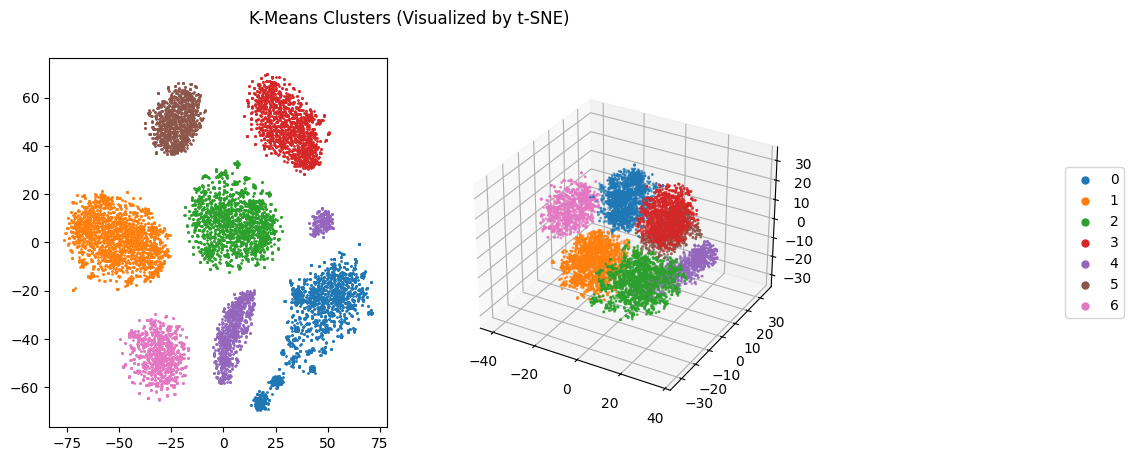

In [14]:
kmeans = KMeans(7)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [21]:
silhouette_score(vectors, kmeans_prediction)

0.70949984

In [15]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,1907.0,1.0,1907.0,"('pedro@algarvio.me', 1907)",9.0,2.0,"('saltstack_salt', 1822)"
1,2082.0,1.0,2082.0,"('mark@mark-story.com', 2082)",11.0,6.0,"('cakephp_cakephp', 1950)"
2,1976.0,1.0,1976.0,"('thatch45@gmail.com', 1976)",1.0,1976.0,"('saltstack_salt', 1976)"
3,1500.0,1.0,1500.0,"('marijnh@gmail.com', 1500)",11.0,31.0,"('codemirror_CodeMirror', 1046)"
4,1110.0,1.0,1110.0,"('mike@silverorange.com', 1110)",8.0,4.5,"('silverorange_swat', 1053)"
5,1006.0,1.0,1006.0,"('ingo@silverstripe.com', 1006)",29.0,4.0,"('silverstripe_silverstripe-framework', 605)"
6,1103.0,1.0,1103.0,"('p@shedcollective.org', 1103)",23.0,12.0,"('nails_common', 470)"


In [16]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,7.000000,7.0,7.000000,7.000000,7.000000
mean,1526.285714,1.0,1526.285714,13.142857,290.785714
std,461.854492,0.0,461.854492,9.564319,743.175947
min,1006.000000,1.0,1006.000000,1.000000,2.000000
25%,1106.500000,1.0,1106.500000,8.500000,4.250000
50%,1500.000000,1.0,1500.000000,11.000000,6.000000
75%,1941.500000,1.0,1941.500000,17.000000,21.500000
max,2082.000000,1.0,2082.000000,29.000000,1976.000000


In [17]:
clustering_spacy_evaluation(kmeans_prediction, test_data)

,0,1,2,3,4,5,6
length_mean,60.113267,89.800192,53.101721,77.164000,74.749550,148.681909,55.019039
length_std,38.870751,64.121144,36.422916,42.722684,48.370551,87.788820,25.824721
n_uppercase_mean,2.464604,3.889529,1.159413,3.076667,3.383784,12.356859,2.749773
n_uppercase_std,2.518142,3.626974,1.291279,2.043556,2.811256,6.448672,3.236092
polarity_mean,0.000266,0.003244,0.027701,0.014316,0.029505,0.026102,-0.007712
polarity_std,0.153540,0.189677,0.193929,0.189770,0.173313,0.159979,0.177524
subjectivity_mean,0.140582,0.200823,0.189413,0.217341,0.178281,0.288391,0.156708
subjectivity_std,0.253164,0.281435,0.295448,0.297275,0.291990,0.245339,0.277534


In [18]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
We need bytes under Py3 to compute the hash
___
2) 
Add missing import and instantiate a local logger instance.
___
3) 
Marked specific places which need code removal on salt >= <I>
___
4) 
Drop Py2 and six on salt/modules/debian_ip.py
___
5) 
Drop Py2 and six on salt/beacons/ps.py
___
6) 
Skip test for now.

/CC: @cachedout
___
7) 
How the hell did I add `utf-7` instead of `utf-8`.
___
8) 
Warn and reset `worker_threads` to the minimum of 3 if lower.
___
9) 
We can't `continue` on truth values.
___
10) 
Drop Py2 and six on salt/states/logadm.py
_________________

Number of messages in this class: 1907
Most common author:
('pedro@algarvio.me', 1907)
Most common project:
('saltstack_salt', 1822)



________________ Class 1 ________________

___
1) 
Fix error in Sqlite tests.
___
2) 
Fixing fatal errors that would arise if the Exception did not have a parent class.
___
3) 
Foreach is faster than array_map.

When connecting <I> routes, t